Sound classifier for classifying the ragas:

22050


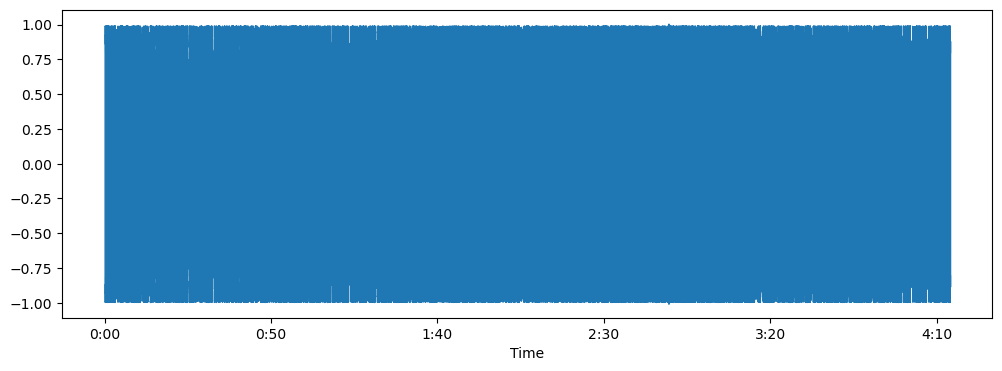

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
filepath="D:\\sound_recog\\music\\asavari\\asavari01.wav"
data,sample_rate=librosa.load(filepath)
plt.figure(figsize=(12,4))
librosa.display.waveshow(data,sr=sample_rate)
print(sample_rate) #22050 is always the sample rate

In [3]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)
# The MFCC summarizes the frequency distribution across the window size. So, it is possible to analyze both the frequency and time characteristics of the sound.

(40, 10944)
[[-5.2337521e+01  7.0209846e+00 -2.0788364e+01 ... -1.1141633e+02
  -1.0939221e+02 -9.8977402e+01]
 [ 1.0819309e+02  1.1022186e+02  1.2749072e+02 ...  1.4107614e+02
   1.4358423e+02  1.5642732e+02]
 [-6.1557112e+00 -1.4267662e+01 -3.7661285e+01 ... -6.1315037e+01
  -5.8226418e+01 -3.9386543e+01]
 ...
 [-5.9190531e+00 -6.6860056e+00 -7.0130777e+00 ... -2.2523870e+00
  -3.8290119e+00 -3.8686972e+00]
 [-2.1672440e+00 -4.4488068e+00 -4.7620001e+00 ... -1.0263822e+00
  -2.1981843e+00  1.8638673e+00]
 [ 1.0482469e+00  8.0426484e-02  2.1567359e+00 ...  1.0728832e+01
   1.0393703e+01  1.0233738e+01]]


In [18]:
import os
from tqdm import tqdm
datas=[]
label=[]

def features_extractor(filepath):
    #load the file (audio)
    audio, sample_rate = librosa.load(filepath) 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

folder_dir="D:\\sound_recog\\music"
for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir,folder)):
        if file.endswith("wav"):
            label.append(folder) #for saving what all classes we are having
            data=features_extractor(os.path.join(folder_dir,folder,file))
            datas.append(data)
        else:
            continue

In [20]:
datas[0]

array([-92.34655   , 161.61327   , -73.48249   ,   4.891001  ,
       -47.1392    ,  -6.7291875 , -31.945724  , -27.507864  ,
       -31.87871   , -24.218998  ,  -6.775172  , -21.23954   ,
        -3.2085097 , -14.992587  ,   0.68249595,  -8.473909  ,
       -21.500202  ,  -9.9012    , -18.66158   , -16.098438  ,
       -11.90452   , -13.500146  , -16.688702  ,  -4.47199   ,
         1.5181869 ,  -8.049293  ,  -7.8329387 ,  -3.333356  ,
        -2.9252336 ,  -1.628698  ,  -1.6260438 ,  -1.5198166 ,
         2.5135458 ,  -1.7779706 ,  -1.3033805 ,   1.9867924 ,
        -7.3332577 ,  -4.1735225 ,   4.0908904 ,   6.1521044 ],
      dtype=float32)

In [21]:
### Split the dataset into independent and dependent dataset
X=np.array(datas)
y=np.array(label)
### Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
### No of classes
num_labels=y.shape[1]
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [23]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [26]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 1000
num_batch_size = 5
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
 1/13 [=>............................] - ETA: 0s - loss: 1.2565 - accuracy: 0.6000
Epoch 1: val_loss improved from inf to 1.87220, saving model to .\audio_classification.hdf5
13/13 [==============================] - 0s 8ms/step - loss: 1.7496 - accuracy: 0.3077 - val_loss: 1.8722 - val_accuracy: 0.1765
Epoch 2/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.2901 - accuracy: 0.2000
Epoch 2: val_loss improved from 1.87220 to 1.86991, saving model to .\audio_classification.hdf5
13/13 [==============================] - 0s 8ms/step - loss: 1.8103 - accuracy: 0.3077 - val_loss: 1.8699 - val_accuracy: 0.1765
Epoch 3/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.0952 - accuracy: 0.2000
Epoch 3: val_loss improved from 1.86991 to 1.86714, saving model to .\audio_classification.hdf5
13/13 [==============================] - 0s 6ms/step - loss: 1.7842 - accuracy: 0.3231 - val_loss: 1.8671 - val_accuracy: 0.1765
Epoch 4/1000
 1/13 [=>...................

In [27]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

1/1 [==============================] - 0s 70ms/step
[2 0 6 4 0 4 3 1 7 5 2 7 2 7 3 7 1]


In [30]:
filename="D:\\sound_recog\\music\\bhairavi\\Bhairavi01.wav"
#preprocess the audio file
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features) 
predicted_label=np.argmax(x_predict,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)

1/1 [==============================] - 0s 16ms/step
[2]
['bhairavi']


In [31]:
filename="D:\\sound_recog\\music\\asavari\\asavari01.wav"
#preprocess the audio file
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features) 
predicted_label=np.argmax(x_predict,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)

1/1 [==============================] - 0s 13ms/step
[0]
['asavari']
